In [1]:
from utils.distributions_sampling_util import *
from utils.plots_util import *
from utils.fits_util import *
import timeit
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

In [2]:
import os
os.environ["PATH"] += os.pathsep + "/usr/local/texlive/2024/bin/universal-darwin"


In [3]:
plt.style.use('latex_style.mplstyle')

# **Parameter Testing and Extended Likelihood Fit**

This section defines the **true model parameters**, tests multiple sets of parameter variations for normalization, and performs the following steps:

1. **Normalization Testing**: Ensure the defined signal and background PDFs integrate correctly over their respective domains.
2. **Distribution Visualization**: Compare the theoretical PDFs with sampled distributions.
3. **Sample Generation**: Generate $100,000$ samples from the joint signal-background model.
4. **Extended Likelihood Fit**: Perform a fit to recover the model parameters using `iminuit` with specified bounds and initial guesses.

---

## **True Parameters and Variations**

The true model parameters are:

$$
\mu = 3, \, \sigma = 0.3, \, \beta = 1, \, m = 1.4, \, \lambda_s = 0.3, \, \mu_b = 0, \, \sigma_b = 2.5, \, f_{\text{signal}} = 0.6
$$

To test normalization robustness, five parameter sets are defined:

1. **True Parameters**: $[3, 0.3, 1, 1.4, 0.3, 0, 2.5, 0.6]$
2. **Slight Variation 1**: $[2.9, 0.31, 1.1, 1.5, 0.4, 0.1, 2.6, 0.7]$
3. **Slight Variation 2**: $[3.1, 0.28, 0.9, 1.3, 0.2, -0.1, 2.4, 0.5]$
4. **Increased Deviations**: $[3.0, 0.35, 1.2, 1.6, 0.25, 0.05, 2.8, 0.65]$
5. **Lower Bound Variation**: $[2.8, 0.25, 1.0, 1.2, 0.35, 0.2, 2.3, 0.55]$

---

## **Parameter Bounds**

To ensure stability during the fit, the following bounds are applied to each parameter:

| **Parameter**           | **Description**                                 | **Bounds**             |
|-------------------------|-------------------------------------------------|------------------------|
| $\mu$                   | Mean of $g_s(X)$                                | $[2.8, 3.2]$           |
| $\sigma$                | Width of Gaussian core in $g_s(X)$              | $[0.05, 0.5]$          |
| $\beta$                 | Transition point to power-law tail              | $[0.5, 1.5]$           |
| $m$                     | Slope of power-law tail in $g_s(X)$             | $[1.0, 2.0]$           |
| $\lambda_s$             | Decay constant for $h_s(Y)$                     | $[0.1, 1.0]$           |
| $\mu_b$                 | Mean of background $h_b(Y)$                     | $[-1, 1]$              |
| $\sigma_b$              | Width of background $h_b(Y)$                    | $[2.0, 4.0]$           |
| $f_{\text{signal}}$     | Signal fraction                                 | $[0.1, 0.9]$           |
| $N_{\text{expected}}$   | Total number of events                          | $[75,000, 125,000]$    |

---

## **Steps in the Code**

1. **Test Normalization**:
   - For each parameter set, verify that the component PDFs integrate to $1$.
   - Output the integral results for $g_s(X), h_s(Y), g_b(X), h_b(Y)$, and the joint $f(X, Y)$.

2. **Visualize Theoretical Distributions**:
   - Plot the **marginal distributions** $g_s(X), g_b(X)$ and $h_s(Y), h_b(Y)$.
   - Compare the combined theoretical distributions with the generated samples.

3. **Sample Generation**:
   - Generate $100,000$ samples from the joint distribution $f(X, Y)$.

4. **Perform Extended Likelihood Fit**:
   - Initialize the fit using `iminuit` with the bounds and an initial guess.
   - Report the fitted parameters and their uncertainties.
   - Print Minuit diagnostics to ensure convergence.

---

## **Output**

- **Normalization Results** for each parameter set.
- Plots of:
   1. **Theoretical Marginal Distributions** in $X$ and $Y$.
   2. **Sampled Distributions** overlaid with the theoretical curves.
   3. **2D Joint Distribution** of $f(X, Y)$.
- **Fit Results**: Recovered parameters, uncertainties, and diagnostics.


Normalization Test Results:

Parameter Set 1: [3, 0.3, 1, 1.4, 0.3, 0, 2.5, 0.6]
  g_s(X): 1.000000
  h_s(Y): 1.000000
  g_b(X): 1.000000
  h_b(Y): 1.000000
  f(X, Y): 1.000000

Parameter Set 2: [2.9, 0.31, 1.1, 1.5, 0.4, 0.1, 2.6, 0.7]
  g_s(X): 1.000000
  h_s(Y): 1.000000
  g_b(X): 1.000000
  h_b(Y): 1.000000
  f(X, Y): 1.000000

Parameter Set 3: [3.1, 0.28, 0.9, 1.3, 0.2, -0.1, 2.4, 0.5]
  g_s(X): 1.000000
  h_s(Y): 1.000000
  g_b(X): 1.000000
  h_b(Y): 1.000000
  f(X, Y): 1.000000

Parameter Set 4: [3.0, 0.35, 1.2, 1.6, 0.25, 0.05, 2.8, 0.65]
  g_s(X): 1.000000
  h_s(Y): 1.000000
  g_b(X): 1.000000
  h_b(Y): 1.000000
  f(X, Y): 1.000000

Parameter Set 5: [2.8, 0.25, 1.0, 1.2, 0.35, 0.2, 2.3, 0.55]
  g_s(X): 1.000000
  h_s(Y): 1.000000
  g_b(X): 1.000000
  h_b(Y): 1.000000
  f(X, Y): 1.000000

Generating distribution plots for params_true...


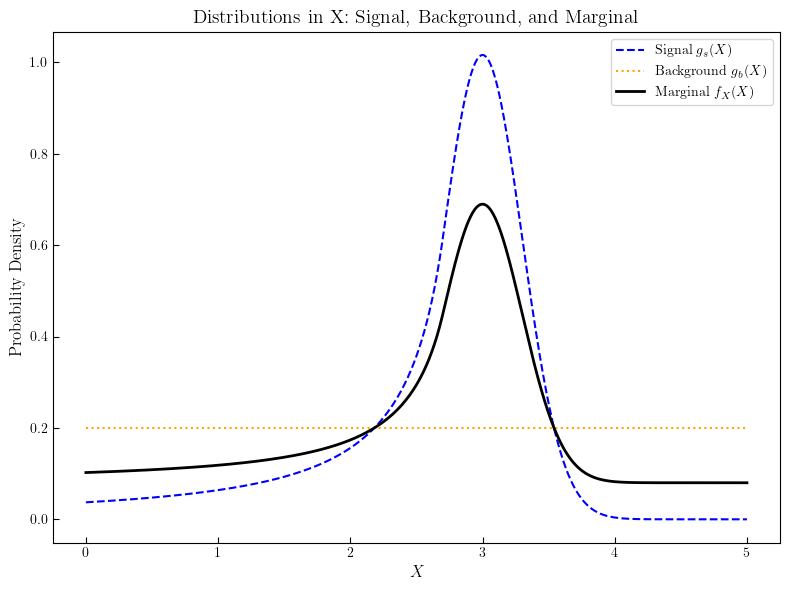

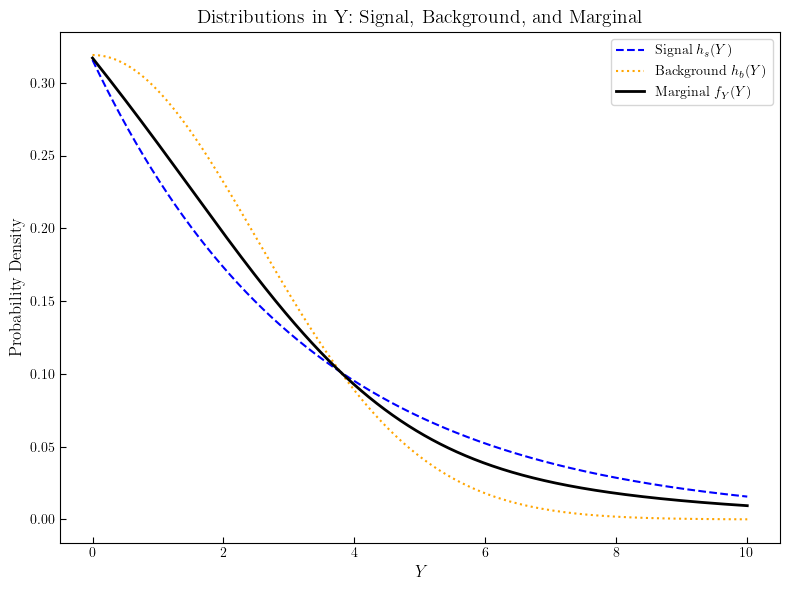

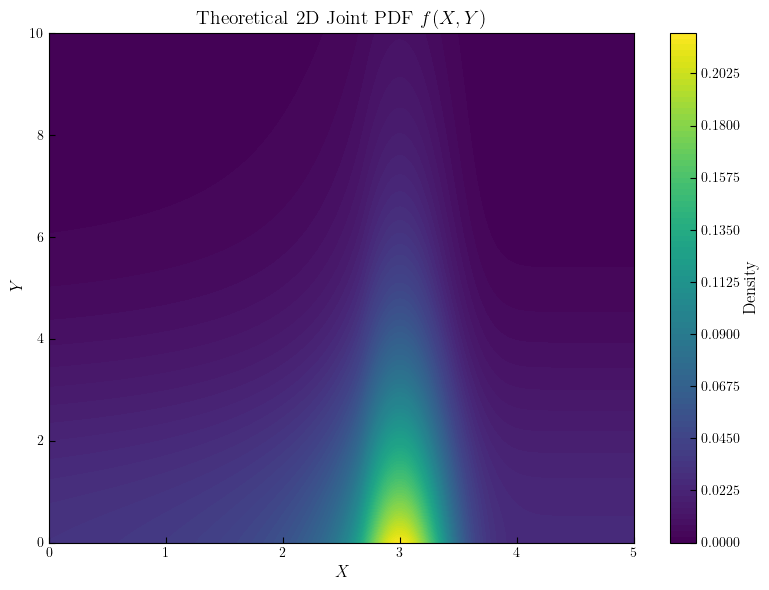


Generating sampled distribution plots...


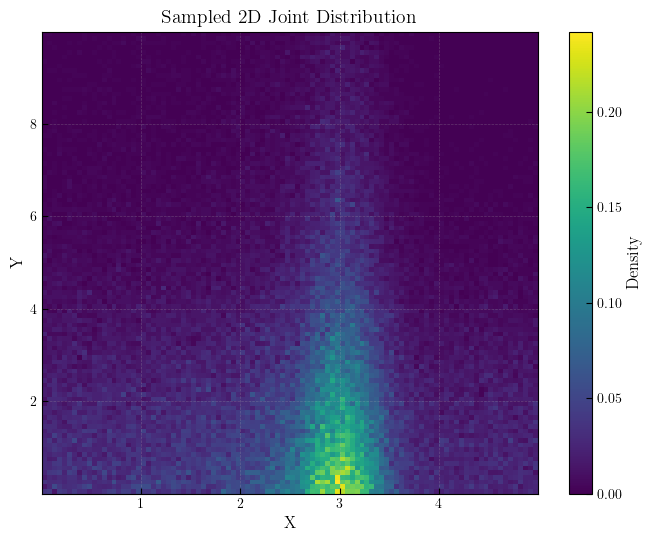

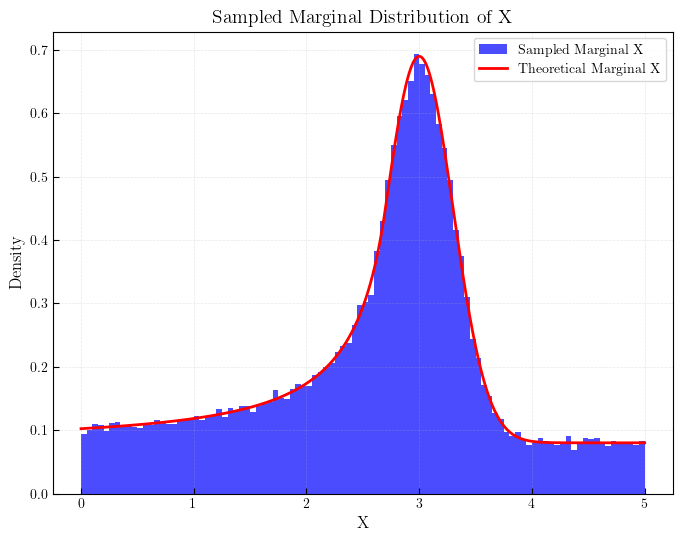

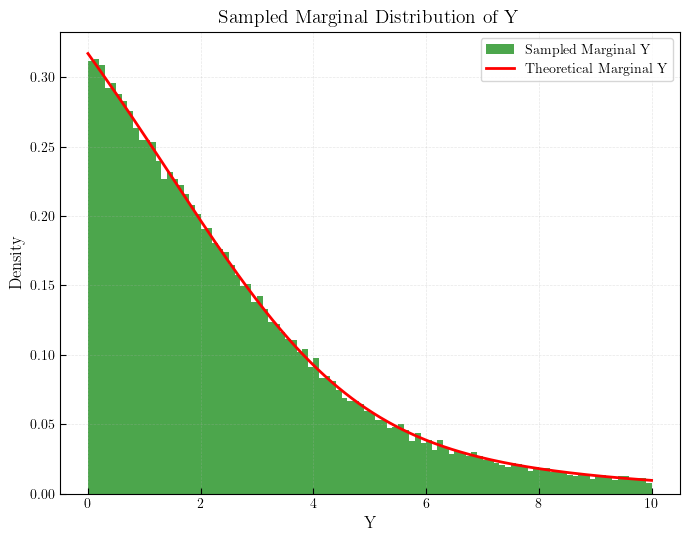

Fit converged successfully.
Fitted parameters: {'mu': 2.9989121000281527, 'sigma': 0.30286168079755393, 'beta': 1.0034837346254233, 'm': 1.4138683076129124, 'lambda_s': 0.30309641486438427, 'mu_b': 0.04369723055886965, 'sigma_b': 2.4828062490758596, 'f_signal': 0.5980008898462152, 'N_expected': 100000.11615018423}
Uncertainties: {'mu': 0.003750014354598097, 'sigma': 0.0035337252927151175, 'beta': 0.033534350004233604, 'm': 0.09553047261028824, 'lambda_s': 0.002928433252787216, 'mu_b': 0.1141523123236522, 'sigma_b': 0.05364685993120699, 'f_signal': 0.005080340758098156, 'N_expected': 447.190502824742}

Fit successful! Fitted parameters:
  mu: 2.9989
  sigma: 0.3029
  beta: 1.0035
  m: 1.4139
  lambda_s: 0.3031
  mu_b: 0.0437
  sigma_b: 2.4828
  f_signal: 0.5980
  N_expected: 100000.1162

Minuit Fit Diagnostics:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├─────────────────────────

In [4]:
# Parameters for testing
params_true = [3, 0.3, 1, 1.4, 0.3, 0, 2.5, 0.6]
params_normalization = [
    params_true,
    [2.9, 0.31, 1.1, 1.5, 0.4, 0.1, 2.6, 0.7],   # Slight variation 1
    [3.1, 0.28, 0.9, 1.3, 0.2, -0.1, 2.4, 0.5],  # Slight variation 2
    [3.0, 0.35, 1.2, 1.6, 0.25, 0.05, 2.8, 0.65], # Slightly increased deviations
    [2.8, 0.25, 1.0, 1.2, 0.35, 0.2, 2.3, 0.55]  # Lower bound variation
]
# Corrected bounds definition
bounds = {
    "mu": (2.8, 3.2),
    "sigma": (0.05, 0.5),
    "beta": (0.5, 1.5),
    "m": (1.0, 2.0),
    "lambda_s": (0.1, 1.0),
    "mu_b": (-1, 1),
    "sigma_b": (2.0, 4.0),
    "f_signal": (0.1, 0.9),
    "N_expected": (0.75 * 100000, 1.25 * 100000)
}

# Step 1: Test normalization for each parameter set
print("Normalization Test Results:")
for i, params in enumerate(params_normalization):
    results = test_normalization(params, 10000)  # Call the test_normalization function for each parameter set
    print(f"\nParameter Set {i + 1}: {params}")
    for dist, value in results.items():
        print(f"  {dist}: {value:.6f}")

# Step 2: Plot distributions for params_true
print("\nGenerating distribution plots for params_true...")
plot_distributions(params_true)

x_samples, y_samples = sample_componentwise(100000, params_true)

# Step 4: Plot sampled distributions
print("\nGenerating sampled distribution plots...")
plot_sampled_distributions(x_samples, y_samples, params_true)

# Define initial guesses and bounds for the fit
initial_guess = {
    "mu": 3.2,
    "sigma": 0.2,
    "beta": 1.2,
    "m": 1.2,
    "lambda_s": 0.5,
    "mu_b": 0.3,
    "sigma_b": 2.7,
    "f_signal": 0.5,
    "N_expected": 100000
}


# Perform the fit and retrieve Minuit object
fit_result, m = perform_fit(x_samples, y_samples, bounds, initial_guess, return_minuit=True)

if fit_result["converged"]:
    print("\nFit successful! Fitted parameters:")
    for param, value in fit_result["parameters"].items():
        print(f"  {param}: {value:.4f}")
    
    # Display Minuit diagnostics
    print("\nMinuit Fit Diagnostics:")
    print(m)

else:
    print("\nFit failed. Cannot generate surface comparison or diagnostics.")


## Benchmarking Execution Times

This section benchmarks the execution times for three key processes involved in the workflow:

1. **Random Sampling** (`np.random.normal`): Baseline random number generation for comparison.
2. **Componentwise Sample Generation**: Sampling data from the defined **signal** and **background distributions**.
3. **Maximum Likelihood Fit**: Performing the extended likelihood fit to estimate model parameters using the generated samples.

### **Purpose**
- Measure the computational efficiency of each task.
- Compare relative execution times against a baseline (`np.random.normal`).
- Assess variability in execution times using average values and standard deviations.

---

### **Benchmarking Method**
1. **Repeated Timing**: Each task is timed **100 times** (configurable using `n_calls`).
   - Timing is performed using `timeit.repeat` for precision and consistency.
2. **Tasks Measured**:
   - **Task 1**: `np.random.normal` baseline random sampling.
   - **Task 2**: Componentwise sample generation using the signal and background distributions.
   - **Task 3**: Maximum likelihood fit using `perform_fit`.

3. **Performance Metrics**:
   - **Average Time**: Mean execution time (seconds) over all repetitions.
   - **Standard Deviation**: Variability in execution times across repetitions.
   - **Relative Time**: Execution time normalized relative to the baseline (`np.random.normal`).

---

### **Results**
The results are presented in a **tabular format** with the following columns:
| **Task**                  | **Average Time (s)** | **Std Dev (s)** | **Relative Time** |
|---------------------------|----------------------|-----------------|------------------|
| `np.random.normal`        | Baseline             | Variability     | 1.00             |
| Componentwise Sampling    | Time for sample gen  | Variability     | Relative to baseline |
| Maximum Likelihood Fit    | Time for fitting     | Variability     | Relative to baseline |




In [12]:
def time_benchmark(bounds, initial_guess, params, size=100000, n_calls=100):
    """
    Benchmark execution times for:
    1. np.random.normal
    2. Componentwise sample generation
    3. Maximum likelihood fitting using generated samples

    Parameters:
    - bounds: Bounds for parameter fitting.
    - initial_guess: Initial parameter guesses for the fit.
    - params: True model parameters used for sampling.
    - size: Number of events to generate.
    - n_calls: Number of calls to average for benchmarking.

    Returns:
    - DataFrame containing times and relative times with std deviations.
    """
    # 1. Benchmark np.random.normal
    normal_times = timeit.repeat(
        stmt="np.random.normal(0, 1, size=size)",
        setup="import numpy as np",
        globals={"size": size},
        repeat=n_calls,
        number=1
    )
    normal_time_avg = np.mean(normal_times)
    normal_time_std = np.std(normal_times)

    # 2. Benchmark componentwise sample generation
    def generate_samples():
        return sample_componentwise(size, params)

    sample_times = timeit.repeat(
        stmt="generate_samples()",
        globals={"generate_samples": generate_samples},
        repeat=n_calls,
        number=1
    )
    sample_time_avg = np.mean(sample_times)
    sample_time_std = np.std(sample_times)

    # Generate a single sample for fitting
    x_samples, y_samples = sample_componentwise(size, params)

    # 3. Benchmark maximum likelihood fitting
    fit_times = timeit.repeat(
        stmt="perform_fit(x_samples, y_samples, bounds, initial_guess)",
        globals={"perform_fit": perform_fit, "x_samples": x_samples, "y_samples": y_samples,
                 "bounds": bounds, "initial_guess": initial_guess},
        repeat=n_calls,
        number=1
    )
    fit_time_avg = np.mean(fit_times)
    fit_time_std = np.std(fit_times)

    # Compute relative times
    sample_relative_avg = sample_time_avg / normal_time_avg
    fit_relative_avg = fit_time_avg / normal_time_avg

    # Compile results into a DataFrame
    data = {
        "Task": ["np.random.normal", "Componentwise Sampling", "Maximum Likelihood Fit"],
        "Average Time (s)": [normal_time_avg, sample_time_avg, fit_time_avg],
        "Std Dev (s)": [normal_time_std, sample_time_std, fit_time_std],
        "Relative Time": [1.0, sample_relative_avg, fit_relative_avg]
    }
    df_results = pd.DataFrame(data)

    return df_results

# Benchmarking settings
size = 100000  # Number of samples
n_calls = 100  # Number of repetitions for benchmarking

# Run the benchmark
print("\nBenchmarking execution times...")
df_results = time_benchmark(bounds, initial_guess, params_true, size, n_calls)

# Display results
print("\nExecution Times and Relative Benchmarks:")
print(df_results.to_string(index=False))



Benchmarking execution times...
Fit converged successfully.
Fitted parameters: {'mu': 2.998786863130749, 'sigma': 0.3021821467443531, 'beta': 0.9924282451576558, 'm': 1.4085450485005073, 'lambda_s': 0.3028810540091545, 'mu_b': -0.01281463599483823, 'sigma_b': 2.5179176164355193, 'f_signal': 0.6029846814060852, 'N_expected': 100000.11616751587}
Uncertainties: {'mu': 0.003622939680916648, 'sigma': 0.0034044923431881535, 'beta': 0.03129926851511089, 'm': 0.09035180772376084, 'lambda_s': 0.0029178098185858037, 'mu_b': 0.1193734346918256, 'sigma_b': 0.055557740733166217, 'f_signal': 0.005042658416384238, 'N_expected': 447.1903234724159}
Fit converged successfully.
Fitted parameters: {'mu': 2.998786863130749, 'sigma': 0.3021821467443531, 'beta': 0.9924282451576558, 'm': 1.4085450485005073, 'lambda_s': 0.3028810540091545, 'mu_b': -0.01281463599483823, 'sigma_b': 2.5179176164355193, 'f_signal': 0.6029846814060852, 'N_expected': 100000.11616751587}
Uncertainties: {'mu': 0.003622939680916648, '

### **Bootstrap Simulation Study: Bias and Uncertainty in Parameter Estimation**

This section describes a **bootstrap simulation study** to evaluate the **bias** and **uncertainty** in the fitted decay constant $\lambda$ as a function of sample size. A single likelihood fit is performed directly on the joint signal-background model.

---

#### **Methodology**

1. **Likelihood Function**:  
   The joint signal-background PDF $f(X, Y)$ combines the signal and background contributions:
   $$
   f(X, Y) = f_{\text{signal}} \cdot g_s(X) \cdot h_s(Y) + (1 - f_{\text{signal}}) \cdot g_b(X) \cdot h_b(Y),
   $$
   where $g_s(X)$, $h_s(Y)$, $g_b(X)$, and $h_b(Y)$ represent the respective signal and background PDFs.

   The **extended negative log-likelihood** (NLL) used for fitting is:
   $$
   \mathcal{L} = -N_{\text{expected}} + N \log(N_{\text{expected}}) + \sum_{i} \log \left[ f_{\text{signal}} g_s(X_i) h_s(Y_i) + (1 - f_{\text{signal}}) g_b(X_i) h_b(Y_i) \right].
   $$

2. **Bootstrap Procedure**:
   - **Poisson Variations**: For each bootstrap trial, the sample size is drawn from a **Poisson distribution** centered on the nominal size.
   - **Maximum Likelihood Fit**: For each Poisson sample, the likelihood fit is performed to estimate the decay constant $\lambda$ (parameter in $h_s(Y)$).
   
3. **Sample Sizes**:  
   The study is repeated for sample sizes:
   $$
   500, \, 1000, \, 2500, \, 5000, \, 10000.
   $$

4. **Bias and Uncertainty**:
   - **Bias**: The difference between the mean fitted $\lambda$ and the true value $\lambda_{\text{true}} = 0.3$:
     $$
     \text{Bias} = \overline{\lambda_{\text{fit}}} - \lambda_{\text{true}}.
     $$
   - **Uncertainty**: The standard deviation of the fitted $\lambda$ values:
     $$
     \sigma_{\lambda} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left( \lambda_i - \overline{\lambda} \right)^2}.
     $$

5. **Error Bars**:
   - **Bias Error**: Standard error of the mean bias:
     $$
     \text{Error on Bias} = \frac{\sigma_{\lambda}}{\sqrt{n}}.
     $$
   - **Uncertainty Error**: Standard error of the uncertainty:
     $$
     \text{Error on Uncertainty} = \frac{\sigma_{\lambda}}{\sqrt{2(n-1)}}.
     $$

---

By repeatedly fitting simulated data, this method estimates the **bias** and **uncertainty** of $\lambda$, as well as the precision of these measurements.


In [5]:
def bootstrap_study(bounds, true_lambda, params, n_trials=250):
    sample_sizes = [500, 1000, 2500, 5000, 10000]
    results = {
        "sample_size": [],
        "mean_lambda": [],
        "std_lambda": [],
        "bias": [],
        "bias_error": [],
        "uncertainty_error": [],
        "average_parameters": {},
    }

    for sample_size in sample_sizes:
        fitted_lambdas = []
        fitted_parameters = {param: [] for param in bounds.keys()}

        for _ in range(n_trials):
            poisson_sample_size = np.random.poisson(sample_size)
            x_samples, y_samples = sample_componentwise(poisson_sample_size, params)

            initial_guess = {
                "mu": 3.2, "sigma": 0.2, "beta": 1.2, "m": 1.2,
                "lambda_s": 0.5, "mu_b": 0.3, "sigma_b": 2.7,
                "f_signal": 0.5, "N_expected": poisson_sample_size
            }

            dynamic_bounds = bounds.copy()
            dynamic_bounds["N_expected"] = (
                0.75 * poisson_sample_size, 1.25 * poisson_sample_size
            )

            fit_result = perform_fit(x_samples, y_samples, dynamic_bounds, initial_guess)

            if fit_result["converged"]:
                fitted_lambdas.append(fit_result["parameters"]["lambda_s"])
                for param in fit_result["parameters"]:
                    fitted_parameters[param].append(fit_result["parameters"][param])

        mean_lambda = np.mean(fitted_lambdas)
        std_lambda = np.std(fitted_lambdas)
        bias = mean_lambda - true_lambda

        # Calculate error bars
        bias_error = std_lambda / np.sqrt(len(fitted_lambdas))
        uncertainty_error = std_lambda / np.sqrt(2 * (len(fitted_lambdas) - 1))

        avg_params = {param: np.mean(values) for param, values in fitted_parameters.items()}
        results["average_parameters"][sample_size] = avg_params

        results["sample_size"].append(sample_size)
        results["mean_lambda"].append(mean_lambda)
        results["std_lambda"].append(std_lambda)
        results["bias"].append(bias)
        results["bias_error"].append(bias_error)
        results["uncertainty_error"].append(uncertainty_error)

        print(f"Sample Size: {sample_size}, Bias: {bias:.4f} ± {bias_error:.4f}, "
              f"Uncertainty: {std_lambda:.4f} ± {uncertainty_error:.4f}")

    return results


def report_average_parameters(results):
    """
    Print the average fitted parameters for each sample size.
    """
    for sample_size, avg_params in results["average_parameters"].items():
        print(f"\nSample Size: {sample_size}")
        for param, value in avg_params.items():
            print(f"  {param}: {value:.4f}")


# Define bounds for the parameters
bounds = {
    "mu": (2.8, 3.2),
    "sigma": (0.05, 0.5),
    "beta": (0.5, 1.5),
    "m": (1.0, 2.0),
    "lambda_s": (0.1, 1.0),
    "mu_b": (-1, 1),
    "sigma_b": (2.0, 4.0),
    "f_signal": (0.1, 0.9),
    "N_expected": (0.75 * 100000, 1.25 * 100000)
}
# Perform the bootstrap study
true_lambda = 0.3  # True decay constant

results = bootstrap_study(bounds, true_lambda, params_true)

# Report average parameters
report_average_parameters(results)


Fit converged successfully.
Fitted parameters: {'mu': 3.0441930474396433, 'sigma': 0.2080147917727006, 'beta': 0.6513117328003728, 'm': 1.9999918484043877, 'lambda_s': 0.25429602894839315, 'mu_b': 0.7647858078803282, 'sigma_b': 2.084879225668849, 'f_signal': 0.5986567551123709, 'N_expected': 507.00015962437817}
Uncertainties: {'mu': 0.0449612912280839, 'sigma': 0.03942202668895997, 'beta': 0.15543585908278712, 'm': 0.93331199840758, 'lambda_s': 0.03765269257711612, 'mu_b': 1.6480335923930225, 'sigma_b': 1.1698580710781399, 'f_signal': 0.05644153395941914, 'N_expected': 31.509456368119373}
Fit converged successfully.
Fitted parameters: {'mu': 2.9990693033320834, 'sigma': 0.31359851483957357, 'beta': 1.1461455698424594, 'm': 1.1859064545611362, 'lambda_s': 0.36292803701770326, 'mu_b': 0.5433974838269746, 'sigma_b': 2.346272503860953, 'f_signal': 0.6424009177428166, 'N_expected': 482.0001579052069}
Uncertainties: {'mu': 0.03820940572272602, 'sigma': 0.03785312709338945, 'beta': 0.28423808

### **Bootstrap Simulation Study with s-Weights: Bias and Uncertainty in Parameter Estimation**

This section outlines a **bootstrap simulation study** where **s-weights** are applied to evaluate the **bias** and **uncertainty** in the decay constant $\lambda$. The method involves a two-step likelihood fitting process in the $X$- and $Y$-dimensions.

---

#### **Methodology**

1. **Two-Step Fit Process**:
   - **Fit in $X$ (Step 1)**:  
     Perform a **maximum likelihood fit** in the $X$-dimension to estimate the signal/background contributions.  
     The likelihood function for this fit is:
     $$
     \mathcal{L}_{X} = -N_{\text{expected}} + N \log(N_{\text{expected}}) + \sum_{i} \log \left[ f_{\text{signal}} g_s(X_i) + (1 - f_{\text{signal}}) g_b(X_i) \right].
     $$
     From this fit, the **s-weights** for each $X$-sample are calculated as:
     $$
     w_i = \frac{f_{\text{signal}} g_s(X_i)}{f_{\text{signal}} g_s(X_i) + (1 - f_{\text{signal}}) g_b(X_i)}.
     $$

   - **Fit in $Y$ with s-Weights (Step 2)**:  
     Perform a **weighted likelihood fit** in the $Y$-dimension using the generated s-weights. The weighted likelihood function is:
     $$
     \mathcal{L}_{Y} = \sum_{i} w_i \log \left[ h_s(Y_i) \right].
     $$
     Here, $h_s(Y)$ is the signal PDF with the decay parameter $\lambda$.

2. **Poisson Variations**:  
   For each bootstrap trial, the sample size is drawn from a **Poisson distribution** centered on the nominal size.

3. **Sample Sizes**:  
   The study is performed for the following sample sizes:
   $$
   500, \, 1000, \, 2500, \, 5000, \, 10000.
   $$

4. **Bias and Uncertainty**:
   - **Bias**: The difference between the mean fitted $\lambda$ and the true value $\lambda_{\text{true}} = 0.3$:
     $$
     \text{Bias} = \overline{\lambda_{\text{fit}}} - \lambda_{\text{true}}.
     $$
   - **Uncertainty**: The standard deviation of the fitted $\lambda$ values:
     $$
     \sigma_{\lambda} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left( \lambda_i - \overline{\lambda} \right)^2}.
     $$

5. **Error Bars**:
   - **Bias Error**: Standard error of the mean bias:
     $$
     \text{Error on Bias} = \frac{\sigma_{\lambda}}{\sqrt{n}}.
     $$
   - **Uncertainty Error**: Standard error of the uncertainty:
     $$
     \text{Error on Uncertainty} = \frac{\sigma_{\lambda}}{\sqrt{2(n-1)}}.
     $$

---

By performing this two-step procedure, the method isolates the signal contribution using s-weights and estimates the **bias** and **uncertainty** in the decay constant $\lambda$, along with their respective errors.


In [6]:
from iminuit import Minuit
import numpy as np

def fit_X(x_samples, bounds, initial_guess):
    """
    Perform an extended likelihood fit in the X dimension only.

    Args:
        x_samples (array): Array of X samples.
        bounds (dict): A dictionary of parameter bounds for the fit.
        initial_guess (dict): A dictionary of initial parameter guesses.

    Returns:
        dict: Fitted parameters, uncertainties, and s-weights for each sample.
    """
    def negative_log_likelihood(mu, sigma, beta, m, f_signal, N_expected):
        try:
            # Precompute normalization constant for g_s(X)
            g_s_norm = crystal_ball_normalization_truncated(mu, sigma, beta, m, lower=0, upper=5)

            # Compute the signal and background PDFs
            signal_pdf = g_s_vectorized(x_samples, mu, sigma, beta, m, g_s_norm)
            background_pdf = g_b_vectorized(x_samples)
            
            # Combine signal and background PDFs
            pdf_vals = f_signal * signal_pdf + (1 - f_signal) * background_pdf

            # Ensure numerical stability
            pdf_vals += 1e-10

            # Extended likelihood terms
            log_likelihood = (
                -N_expected
                + len(x_samples) * np.log(N_expected)
                + np.sum(np.log(pdf_vals))
            )

            return -log_likelihood
        except Exception as e:
            print(f"Error in likelihood calculation: {e}")
            return 1e10

    # Initialize Minuit for the fit
    m = Minuit(negative_log_likelihood, **initial_guess)

    # Set bounds
    for param, bound in bounds.items():
        m.limits[param] = bound

    # Perform the fit
    m.migrad()
    m.hesse()

    if not m.valid:
        raise ValueError("Fit did not converge")

    # Extract the fitted parameters
    params = {name: value for name, value in zip(m.parameters, m.values)}

    # Calculate s-weights
    g_s_norm = crystal_ball_normalization_truncated(
        params["mu"], params["sigma"], params["beta"], params["m"], lower=0, upper=5
    )
    signal_pdf = g_s_vectorized(x_samples, params["mu"], params["sigma"], params["beta"], params["m"], g_s_norm)
    background_pdf = g_b_vectorized(x_samples)
    s_weights = (params["f_signal"] * signal_pdf) / (
        params["f_signal"] * signal_pdf + (1 - params["f_signal"]) * background_pdf
    )

    return {
        "parameters": params,
        "uncertainties": {name: error for name, error in zip(m.parameters, m.errors)},
        "s_weights": s_weights
    }

def fit_Y_weighted(y_samples, s_weights, bounds, initial_guess):
    """
    Perform a weighted fit in the Y dimension using s-weights.

    Args:
        y_samples (array): Array of Y samples.
        s_weights (array): Array of s-weights.
        bounds (dict): Bounds for the fit.
        initial_guess (dict): Initial guesses for the fit.

    Returns:
        dict: Fitted parameters and uncertainties for λ.
    """
    def weighted_negative_log_likelihood(lambda_s):
        try:
            # Compute the signal PDF h_s(Y)
            signal_pdf = h_s_vectorized(y_samples, lambda_s)

            # Weighted likelihood
            weighted_likelihood = s_weights * np.log(signal_pdf + 1e-10)
            return -np.sum(weighted_likelihood)
        except Exception as e:
            print(f"Error in likelihood calculation: {e}")
            return 1e10

    # Initialize Minuit
    m = Minuit(weighted_negative_log_likelihood, **initial_guess)

    # Set bounds
    for param, bound in bounds.items():
        m.limits[param] = bound

    # Perform the fit
    m.migrad()
    m.hesse()

    if not m.valid:
        raise ValueError("Fit did not converge")

    # Return the results
    return {
        "parameters": {name: value for name, value in zip(m.parameters, m.values)},
        "uncertainties": {name: error for name, error in zip(m.parameters, m.errors)}
    }
    
def bootstrap_s_weights_with_poisson(bounds_X, bounds_Y, true_lambda, params, n_trials=250, max_retries=3):
    """
    Perform a bootstrap simulation study with Poisson variation on sample size.

    Args:
        bounds_X: Parameter bounds for the fit in X.
        bounds_Y: Parameter bounds for the fit in Y.
        true_lambda: True value of the decay constant λ to compare bias.
        params: True model parameters for sampling.
        n_trials: Number of bootstrap trials for each sample size.
        max_retries: Maximum number of retries for the fit in X.

    Returns:
        results: A dictionary containing biases, uncertainties, error bars, and sample sizes.
    """
    sample_sizes = [500, 1000, 2500, 5000, 10000]
    results = {
        "sample_size": [],
        "mean_lambda": [],
        "std_lambda": [],
        "bias": [],
        "bias_error": [],
        "uncertainty_error": [],
    }

    for sample_size in sample_sizes:
        fitted_lambdas = []

        for _ in range(n_trials):
            poisson_sample_size = np.random.poisson(sample_size)
            x_samples, y_samples = sample_componentwise(poisson_sample_size, params)

            fit_X_result = None
            for attempt in range(max_retries):
                try:
                    initial_guess_X = {
                        "mu": 3.2, "sigma": 0.2, "beta": 1.2,
                        "m": 1.2, "f_signal": 0.5,
                        "N_expected": poisson_sample_size
                    }
                    dynamic_bounds_X = bounds_X.copy()
                    dynamic_bounds_X["N_expected"] = (
                        0.75 * poisson_sample_size, 1.25 * poisson_sample_size
                    )
                    fit_X_result = fit_X(x_samples, dynamic_bounds_X, initial_guess_X)
                    break
                except ValueError:
                    continue

            if fit_X_result is None:
                continue

            try:
                s_weights = fit_X_result["s_weights"]
                initial_guess_Y = {"lambda_s": 0.3}
                fit_Y_result = fit_Y_weighted(y_samples, s_weights, bounds_Y, initial_guess_Y)
                fitted_lambdas.append(fit_Y_result["parameters"]["lambda_s"])
            except ValueError:
                continue

        if fitted_lambdas:
            mean_lambda = np.mean(fitted_lambdas)
            std_lambda = np.std(fitted_lambdas)
            bias = mean_lambda - true_lambda

            # Calculate error bars
            bias_error = std_lambda / np.sqrt(len(fitted_lambdas))
            uncertainty_error = std_lambda / np.sqrt(2 * (len(fitted_lambdas) - 1))

            results["sample_size"].append(sample_size)
            results["mean_lambda"].append(mean_lambda)
            results["std_lambda"].append(std_lambda)
            results["bias"].append(bias)
            results["bias_error"].append(bias_error)
            results["uncertainty_error"].append(uncertainty_error)

            print(f"Sample Size: {sample_size}, Bias: {bias:.4f} ± {bias_error:.4f}, "
                  f"Uncertainty: {std_lambda:.4f} ± {uncertainty_error:.4f}")

    return results


# Define bounds for X and Y fits
bounds_X = {
    "mu": (2.8, 3.2),         # Wider range for mu
    "sigma": (0.05, 0.5),      # Allow more flexibility for sigma
    "beta": (0.5, 1.5),       # Include a wider range for beta
    "m": (1.0, 2.0),          # Expand m range
    "f_signal": (0.1, 0.9),   # Include full range for f_signal
    "N_expected": (400, 600)  # Allow variation in expected sample size
}


bounds_Y = {
    "lambda_s": (0.1, 1.0)
}

# Run bootstrap study
true_lambda = 0.3
results_method2 = bootstrap_s_weights_with_poisson(bounds_X, bounds_Y, true_lambda, params_true)




Sample Size: 500, Bias: 0.0402 ± 0.0013, Uncertainty: 0.0203 ± 0.0009
Sample Size: 1000, Bias: 0.0420 ± 0.0010, Uncertainty: 0.0163 ± 0.0007
Sample Size: 2500, Bias: 0.0398 ± 0.0006, Uncertainty: 0.0098 ± 0.0004
Sample Size: 5000, Bias: 0.0408 ± 0.0004, Uncertainty: 0.0067 ± 0.0003
Sample Size: 10000, Bias: 0.0399 ± 0.0003, Uncertainty: 0.0049 ± 0.0002


### **Comparison of Bias and Uncertainty Across Two Methods**

This section compares the **bias** and **uncertainty** of the decay constant $\lambda$ obtained using two different methods:
1. **Bootstrap Method**: A direct bootstrap simulation study with Poisson variations in sample size.
2. **s-Weights Method**: A two-step fitting process leveraging s-weights to isolate the signal contribution.

---

#### **Visualization**

Two combined plots are generated to compare the performance of both methods, including error bars to represent the precision of the estimates:

1. **Bias Comparison**:
   - The bias in $\lambda$ is plotted as a function of sample size for both methods.
   - A horizontal reference line at $0$ indicates the ideal scenario where no bias is present.
   - Error bars are included to show the statistical uncertainty in the bias estimates.
   - Markers and line styles distinguish the methods:
     - **Bootstrap Method**: Dashed lines with circle markers.
     - **s-Weights Method**: Dash-dot lines with square markers.

2. **Uncertainty Comparison**:
   - The uncertainty ($\sigma_{\lambda}$) in $\lambda$ is plotted as a function of sample size for both methods.
   - Error bars indicate the precision of the uncertainty estimates.
   - The comparison shows how the uncertainty decreases with increasing sample size, as expected.
   - Line styles and markers remain consistent with the bias plot.

---

By including error bars, the plots provide a clearer representation of both the estimates and their precision, allowing for a comprehensive comparison of the two methods.


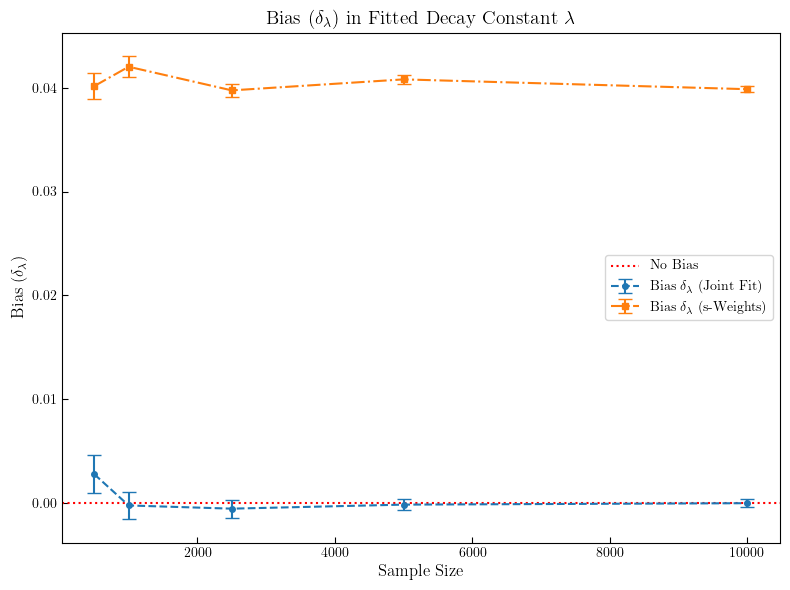

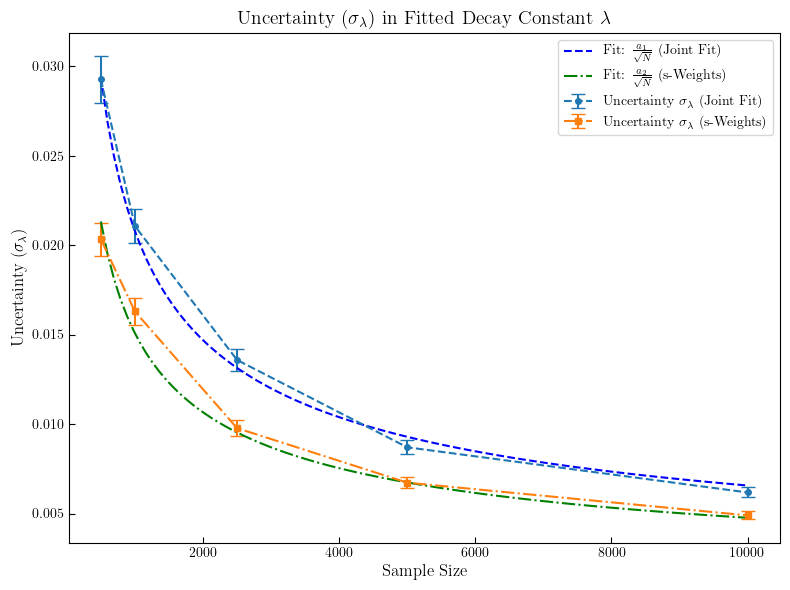

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def inverse_sqrt(x, a):
    """Model function: a / sqrt(x)"""
    return a / np.sqrt(x)

def plot_combined_results_with_errors(results1, results2, labels=["Joint Fit", "s-Weights"]):
    """
    Plot combined bias and uncertainty results with error bars from two methods.
    Fit a 1/sqrt(N) model to the uncertainty data and overlay it on the uncertainty plot.

    Args:
        results1 (dict): Results from the first method (joint fit).
        results2 (dict): Results from the second method (s-weights).
        labels (list): Labels for the methods to display in the legends.

    Returns:
        None
    """
    # Extract data for both methods
    sample_sizes1 = np.array(results1["sample_size"])
    biases1 = np.array(results1["bias"])
    bias_errors1 = np.array(results1["bias_error"])
    uncertainties1 = np.array(results1["std_lambda"])
    uncertainty_errors1 = np.array(results1["uncertainty_error"])

    sample_sizes2 = np.array(results2["sample_size"])
    biases2 = np.array(results2["bias"])
    bias_errors2 = np.array(results2["bias_error"])
    uncertainties2 = np.array(results2["std_lambda"])
    uncertainty_errors2 = np.array(results2["uncertainty_error"])

    # Fit the 1/sqrt(N) model to uncertainties
    popt1, _ = curve_fit(inverse_sqrt, sample_sizes1, uncertainties1)
    popt2, _ = curve_fit(inverse_sqrt, sample_sizes2, uncertainties2)
    a1, a2 = popt1[0], popt2[0]  # Fitted coefficients

    # Create combined Bias Plot with Error Bars
    plt.figure(figsize=(8, 6))
    plt.errorbar(sample_sizes1, biases1, yerr=bias_errors1, fmt="o--", capsize=5, label=f"Bias \(\delta_{{\lambda}}\) ({labels[0]})")
    plt.errorbar(sample_sizes2, biases2, yerr=bias_errors2, fmt="s-.", capsize=5, label=f"Bias \(\delta_{{\lambda}}\) ({labels[1]})")
    plt.axhline(0, color="r", linestyle=":", label="No Bias")
    plt.xlabel("Sample Size")
    plt.ylabel("Bias (\(\delta_{\lambda}\))")
    plt.title("Bias (\(\delta_{\lambda}\)) in Fitted Decay Constant \(\lambda\)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig("Combined_Bias_with_ErrorBars.pdf")
    plt.show()

    # Create combined Uncertainty Plot with Error Bars
    plt.figure(figsize=(8, 6))
    plt.errorbar(sample_sizes1, uncertainties1, yerr=uncertainty_errors1, fmt="o--", capsize=5, label=f"Uncertainty \(\sigma_{{\lambda}}\) ({labels[0]})")
    plt.errorbar(sample_sizes2, uncertainties2, yerr=uncertainty_errors2, fmt="s-.", capsize=5, label=f"Uncertainty \(\sigma_{{\lambda}}\) ({labels[1]})")

    # Overlay the fitted 1/sqrt(N) curves with a1 and a2
    sample_range = np.linspace(min(sample_sizes1), max(sample_sizes1), 100)
    plt.plot(sample_range, inverse_sqrt(sample_range, a1), "b--", label=f"Fit: \( \\frac{{a_1}}{{\sqrt{{N}}}} \) ({labels[0]})")
    plt.plot(sample_range, inverse_sqrt(sample_range, a2), "g-.", label=f"Fit: \( \\frac{{a_2}}{{\sqrt{{N}}}} \) ({labels[1]})")

    plt.xlabel("Sample Size")
    plt.ylabel("Uncertainty (\(\sigma_{\lambda}\))")
    plt.title("Uncertainty (\(\sigma_{\lambda}\)) in Fitted Decay Constant \(\lambda\)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig("Combined_Uncertainty_with_Fit.pdf")
    plt.show()


# Combine and plot results with errors
plot_combined_results_with_errors(results, results_method2, labels=["Joint Fit", "s-Weights"])
